In [1]:
import Get_data as Gd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from CAE import Encoder, Decoder, Autoencoder
from torchinfo import summary
from sklearn.model_selection import train_test_split

In [2]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available
Number of GPUs available: 1
GPU 0: NVIDIA RTX A6000
Using device: cuda:0


# CAE

## Create Dataset for CAE

In [3]:
directory = '/data/Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]

### Train set

In [4]:
# train_np, length = Gd.get_all_nodes(folders[:-2])
# train_np = np.expand_dims(train_np[:, :, 0], axis=2)
# np.random.shuffle(train_np)
# preprocessor = Gd.Preprocessor()

# preprocessor.fit(train_np)
# # preprocessor.max = 1
# # preprocessor.min = 0
# preprocessed_train_np = preprocessor.transform(train_np)

In [5]:
# train_np.shape

In [6]:
# preprocessed_train_tensor = torch.tensor(preprocessed_train_np, dtype=torch.float).permute(0, 2, 1)

# real_train_tensor = torch.tensor(train_np, dtype=torch.float).permute(0, 2, 1)

# train_tensor_set = Gd.MyDataset(preprocessed_train_tensor, real_train_tensor)
# print(preprocessed_train_tensor.max(), real_train_tensor.max())
# print(preprocessed_train_tensor.min(), real_train_tensor.min())

In [7]:
# a, b = train_tensor_set[0]
# print(a.shape, b.shape)

### Test set

In [8]:
# test_np, length = Gd.get_all_nodes(folders[-2:])
# test_np = np.expand_dims(test_np[:, :, 0], axis=2)

# preprocessor_test = Gd.Preprocessor()
# preprocessor_test.fit(test_np)

# preprocessed_test_np = preprocessor_test.transform(test_np)

In [9]:
# preprocessed_test_tensor = torch.tensor(preprocessed_test_np, dtype=torch.float).permute(0, 2, 1)

# real_test_tensor = torch.tensor(test_np, dtype=torch.float).permute(0, 2, 1)

# test_tensor_set = Gd.MyDataset(preprocessed_test_tensor, real_test_tensor)

# print(preprocessed_test_np.max(), real_test_tensor.max())
# print(preprocessed_test_np.min(), real_test_tensor.min())

In [10]:
# train_loader = DataLoader(train_tensor_set, batch_size=1, shuffle=True)
# test_loader = DataLoader(test_tensor_set, batch_size=1, shuffle=True)

### Try only one case

In [11]:
# from sklearn.model_selection import train_test_split
# dataset, length = Gd.get_all_nodes(folders[0:1])
# train_np, test_np = train_test_split(dataset, test_size=0.2, shuffle=True)
# train_np = np.expand_dims(train_np[:, :, 0], axis=2)
# test_np = np.expand_dims(test_np[:, :, 0], axis=2)

# preprocessor = Gd.Preprocessor()
# preprocessor.fit(train_np)
# # preprocessor.max = 1
# # preprocessor.min = 0
# preprocessed_train_np = preprocessor.transform(train_np)
# preprocessed_train_tensor = torch.tensor(preprocessed_train_np, dtype=torch.float).permute(0, 2, 1)
# real_train_tensor = torch.tensor(train_np, dtype=torch.float).permute(0, 2, 1)
# train_tensor_set = Gd.MyDataset(preprocessed_train_tensor, real_train_tensor)

In [12]:
# preprocessed_test_np = preprocessor.transform(test_np)
# preprocessed_test_tensor = torch.tensor(preprocessed_test_np, dtype=torch.float).permute(0, 2, 1)

# real_test_tensor = torch.tensor(test_np, dtype=torch.float).permute(0, 2, 1)

# test_tensor_set = Gd.MyDataset(preprocessed_test_tensor, real_test_tensor)

In [13]:
# train_loader = DataLoader(train_tensor_set, batch_size=1, shuffle=True)
# test_loader = DataLoader(test_tensor_set, batch_size=1, shuffle=True)

### Use all the case

In [14]:
dataset, length = Gd.get_all_nodes(folders)
train_np, test_np = train_test_split(dataset, test_size=0.2, shuffle=True)
train_np = np.expand_dims(train_np[:, :, 0], axis=2)
test_np = np.expand_dims(test_np[:, :, 0], axis=2)

In [15]:
preprocessor = Gd.Preprocessor()
preprocessor.fit(train_np)

preprocessed_train_np = preprocessor.transform(train_np)
preprocessed_train_tensor = torch.tensor(preprocessed_train_np, dtype=torch.float).permute(0, 2, 1)
real_train_tensor = torch.tensor(train_np, dtype=torch.float).permute(0, 2, 1)
train_tensor_set = Gd.MyDataset(preprocessed_train_tensor, real_train_tensor)

In [16]:
preprocessed_test_np = preprocessor.transform(test_np)
preprocessed_test_tensor = torch.tensor(preprocessed_test_np, dtype=torch.float).permute(0, 2, 1)
real_test_tensor = torch.tensor(test_np, dtype=torch.float).permute(0, 2, 1)
test_tensor_set = Gd.MyDataset(preprocessed_test_tensor, real_test_tensor)

In [17]:
train_loader = DataLoader(train_tensor_set, batch_size=1, shuffle=True)
test_loader = DataLoader(test_tensor_set, batch_size=1, shuffle=True)

## Model Info

In [18]:
# Create an instance of the model
encoder = Encoder(1, 50)
summary(encoder, input_size=(10, 1, 97149))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [10, 50]                  --
├─Conv1d: 1-1                            [10, 4, 97149]            36
├─Dropout: 1-2                           [10, 4, 97149]            --
├─MaxPool1d: 1-3                         [10, 4, 19429]            --
├─Conv1d: 1-4                            [10, 4, 19429]            132
├─Dropout: 1-5                           [10, 4, 19429]            --
├─MaxPool1d: 1-6                         [10, 4, 3885]             --
├─Conv1d: 1-7                            [10, 1, 3885]             33
├─LeakyReLU: 1-8                         [10, 1, 3885]             --
├─Dropout: 1-9                           [10, 1, 3885]             --
├─MaxPool1d: 1-10                        [10, 1, 777]              --
├─AdaptiveAvgPool1d: 1-11                [10, 1, 100]              --
├─Flatten: 1-12                          [10, 100]                 --
├─Linear: 1-13

In [19]:
decoder = Decoder(50, 1)
summary(decoder, input_size=(10, 50))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [10, 1, 97149]            --
├─Linear: 1-1                            [10, 512]                 26,112
├─Upsample: 1-2                          [10, 1, 1024]             --
├─Conv1d: 1-3                            [10, 1, 1018]             9
├─Linear: 1-4                            [10, 1, 97149]            98,994,831
├─Conv1d: 1-5                            [10, 1, 97149]            2
├─LeakyReLU: 1-6                         [10, 1, 97149]            --
Total params: 99,020,954
Trainable params: 99,020,954
Non-trainable params: 0
Total mult-adds (M): 992.24
Input size (MB): 0.00
Forward/backward pass size (MB): 15.67
Params size (MB): 396.08
Estimated Total Size (MB): 411.75

In [20]:
model = Autoencoder(1, 50)
summary(model, input_size=(10, 1, 97149))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [10, 1, 97149]            --
├─Encoder: 1-1                           [10, 50]                  --
│    └─Conv1d: 2-1                       [10, 4, 97149]            36
│    └─Dropout: 2-2                      [10, 4, 97149]            --
│    └─MaxPool1d: 2-3                    [10, 4, 19429]            --
│    └─Conv1d: 2-4                       [10, 4, 19429]            132
│    └─Dropout: 2-5                      [10, 4, 19429]            --
│    └─MaxPool1d: 2-6                    [10, 4, 3885]             --
│    └─Conv1d: 2-7                       [10, 1, 3885]             33
│    └─LeakyReLU: 2-8                    [10, 1, 3885]             --
│    └─Dropout: 2-9                      [10, 1, 3885]             --
│    └─MaxPool1d: 2-10                   [10, 1, 777]              --
│    └─AdaptiveAvgPool1d: 2-11           [10, 1, 100]              --
│    └─Flatten

## Train CAE

In [21]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

In [22]:
def train(model, train_loader, test_loader, criterion, optimizer, preprocessor, preprocessor_test, device, epochs=30):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        recon_train_loss = 0
        for x, real_y in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            predict= model(x)
            loss = criterion(x, predict)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            predict_np = predict.permute(0, 2, 1).cpu().detach().numpy()
            recon_predict_np = preprocessor.inverse_transform(predict_np)

            recon_predict_tensor = torch.tensor(recon_predict_np, dtype=torch.float).permute(0, 2, 1)
            recon_train_loss += criterion(real_y, recon_predict_tensor)

        train_loss /= len(train_loader)
        recon_train_loss /= len(train_loader)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            recon_test_loss = 0
            for x, real_y in test_loader:
                x = x.to(device)
                predict= model(x)
                val_loss += criterion(x, predict).item()

                #print(criterion(output, sigmoid(data)))
                predict_np = predict.permute(0, 2, 1).cpu().detach().numpy()
                recon_predict_np = preprocessor_test.inverse_transform(predict_np)
                recon_predict_tensor = torch.tensor(recon_predict_np, dtype=torch.float).permute(0, 2, 1)
                recon_test_loss += criterion(real_y, recon_predict_tensor)

            val_loss /= len(test_loader)
            recon_test_loss /= len(test_loader)
        
        print(f'Epoch {epoch + 1}/{epochs}, train Loss: {train_loss}, recon train loss: {recon_train_loss}, val Loss: {val_loss}, recon val Loss: {recon_test_loss}')


In [23]:
model = Autoencoder(1, 50).to(device)
optimizer = optim.Adam(model.parameters())
criterion = RMSELoss()

train(model, train_loader, test_loader, criterion, optimizer, preprocessor, preprocessor, device)
# 保存模型的状态字典
torch.save(model.state_dict(), 'CAE.pth')

Epoch 1/30, train Loss: 0.10582295250302802, recon train loss: 5.2369513511657715, val Loss: 0.11126756281281511, recon val Loss: 5.506397247314453
Epoch 2/30, train Loss: 0.0784001965347367, recon train loss: 3.879857063293457, val Loss: 0.09221089729107916, recon val Loss: 4.563323974609375
Epoch 3/30, train Loss: 0.06688036654532577, recon train loss: 3.3097686767578125, val Loss: 0.07443157953520615, recon val Loss: 3.6834640502929688
Epoch 4/30, train Loss: 0.058023186171970643, recon train loss: 2.8714468479156494, val Loss: 0.07968925121240318, recon val Loss: 3.9436559677124023
Epoch 5/30, train Loss: 0.05316679578856565, recon train loss: 2.631110906600952, val Loss: 0.07794251500318448, recon val Loss: 3.8572115898132324
Epoch 6/30, train Loss: 0.04948072053317446, recon train loss: 2.4486961364746094, val Loss: 0.06742231846166154, recon val Loss: 3.3365895748138428
Epoch 7/30, train Loss: 0.04651169785337212, recon train loss: 2.301767349243164, val Loss: 0.0670595736863712

## Result

In [24]:
def draw_pic(model, real_x, x, real_output, preprocessor, coords):
    output = model(x.to(device))

    # output.to("cpu")
    output_array = output.cpu().detach().numpy() # [5, 1, 97149]
    recon_output = preprocessor.inverse_transform(output_array)

    fig1, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=real_x[i, :, 0], cmap='bwr')
        axs[i].set_title(f'Input {i+1}')
    plt.show()
    plt.close()

    fig2, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=recon_output[i, 0, :], cmap='bwr')
        axs[i].set_title(f'Predict {i+1}')
    plt.show()
    plt.close()

    fig3, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=real_output[i, :, 0], cmap='bwr')
        axs[i].set_title(f'Real output {i+1}')
    plt.show()
    plt.close()

In [25]:
xyfile = "/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
xycoords_check = np.load(xyfile)

In [26]:
model = Autoencoder(1, 50)
# 加载保存的状态字典
state_dict = torch.load('CAE.pth')
model.load_state_dict(state_dict)
model.to(device)

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv1d(1, 4, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (dropout1): Dropout(p=0.1, inplace=False)
    (pool1): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(4, 4, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (dropout2): Dropout(p=0.1, inplace=False)
    (pool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv1d(4, 1, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (leaky_relu): LeakyReLU(negative_slope=0.3)
    (dropout3): Dropout(p=0.1, inplace=False)
    (pool3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (avg_pool): AdaptiveAvgPool1d(output_size=100)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dense): Linear(in_features=100, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (dense1): Linear(in_features=50, out_features=512, bias=True)
 

In [29]:
real_x = test_np[0:5]
x = torch.tensor(preprocessor.transform(real_x), dtype=torch.float).permute(0, 2, 1)
real_output = real_x

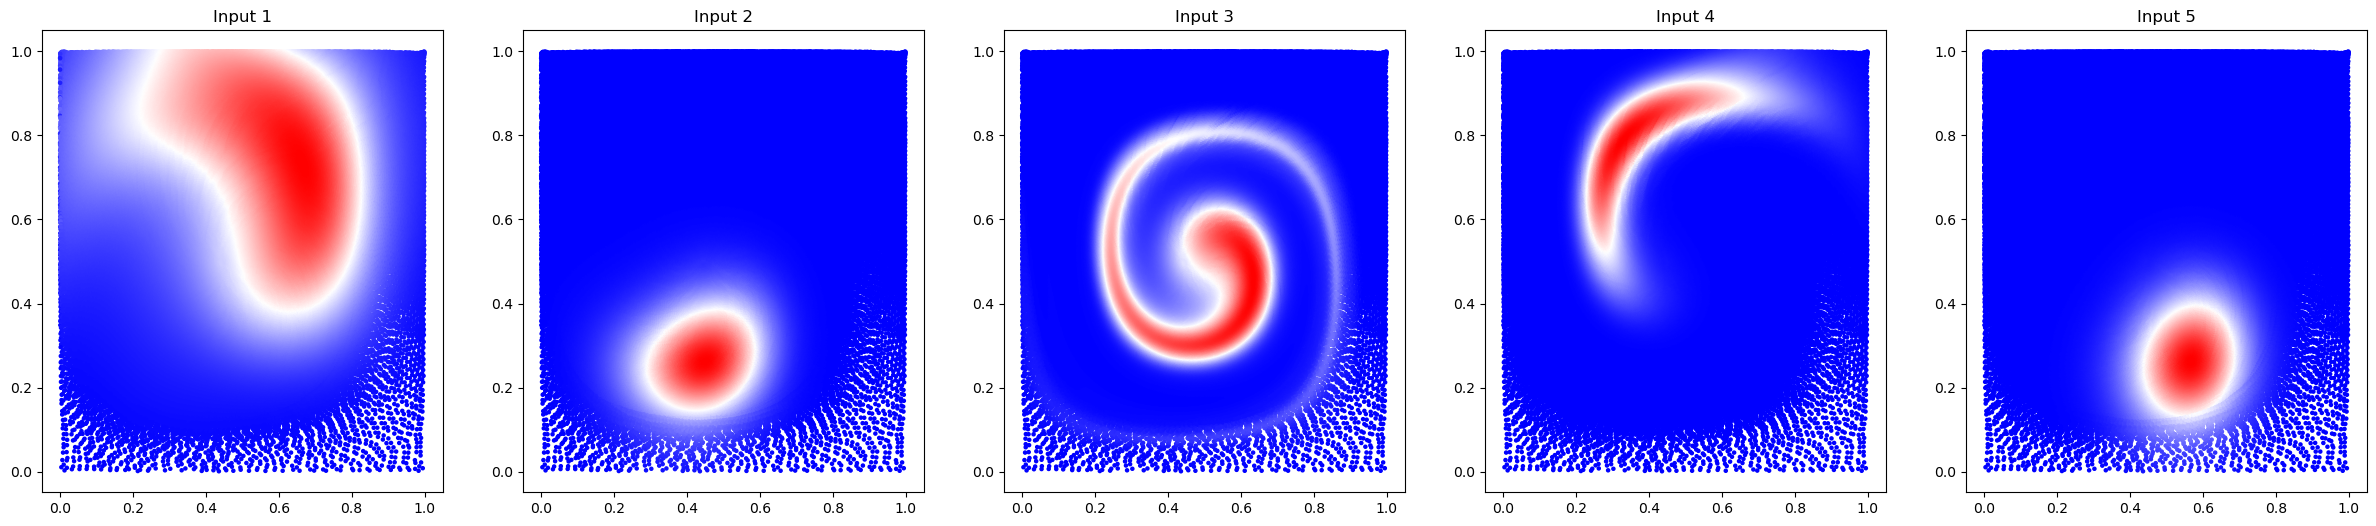

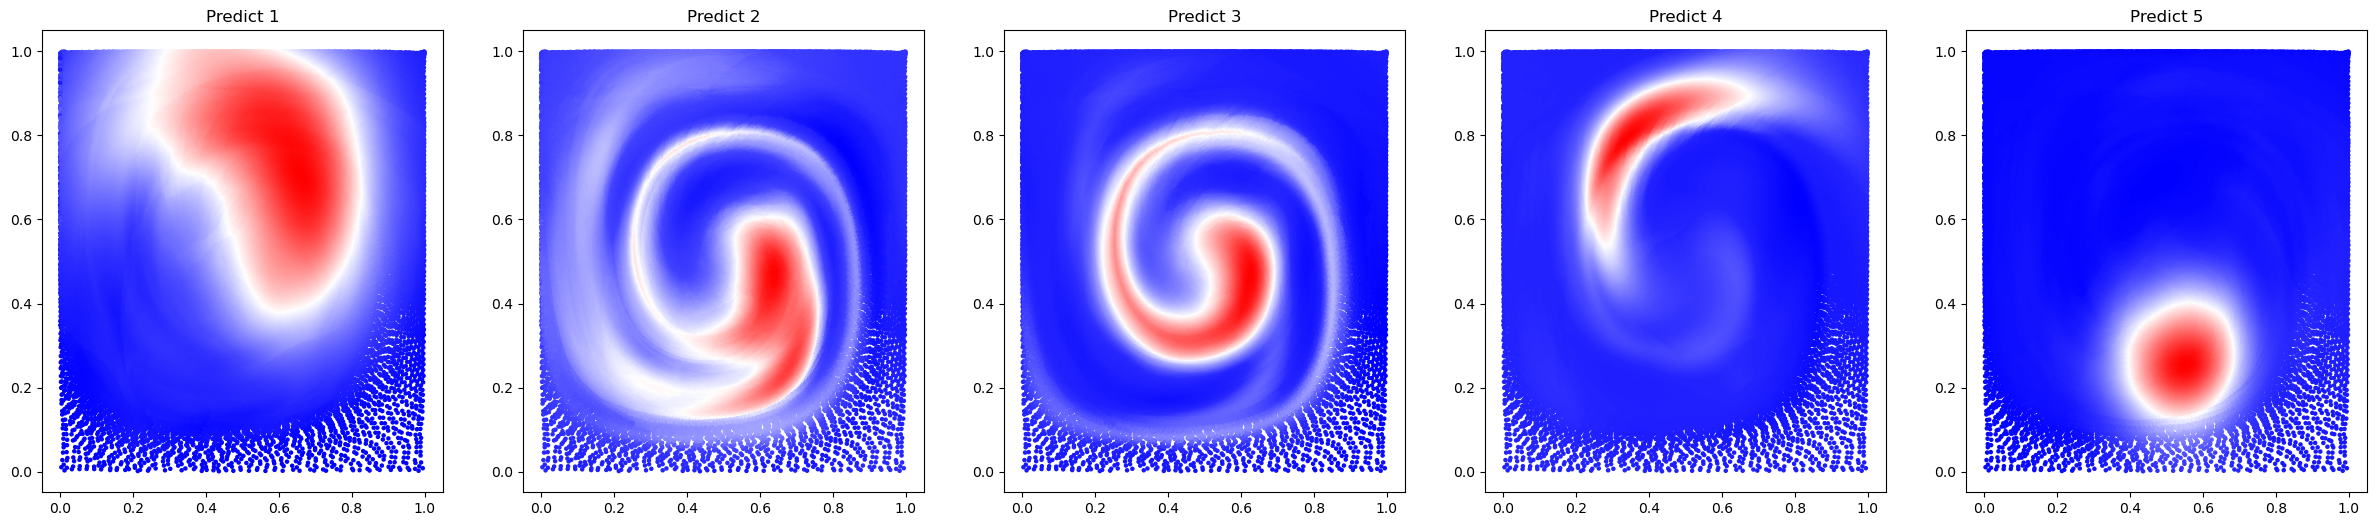

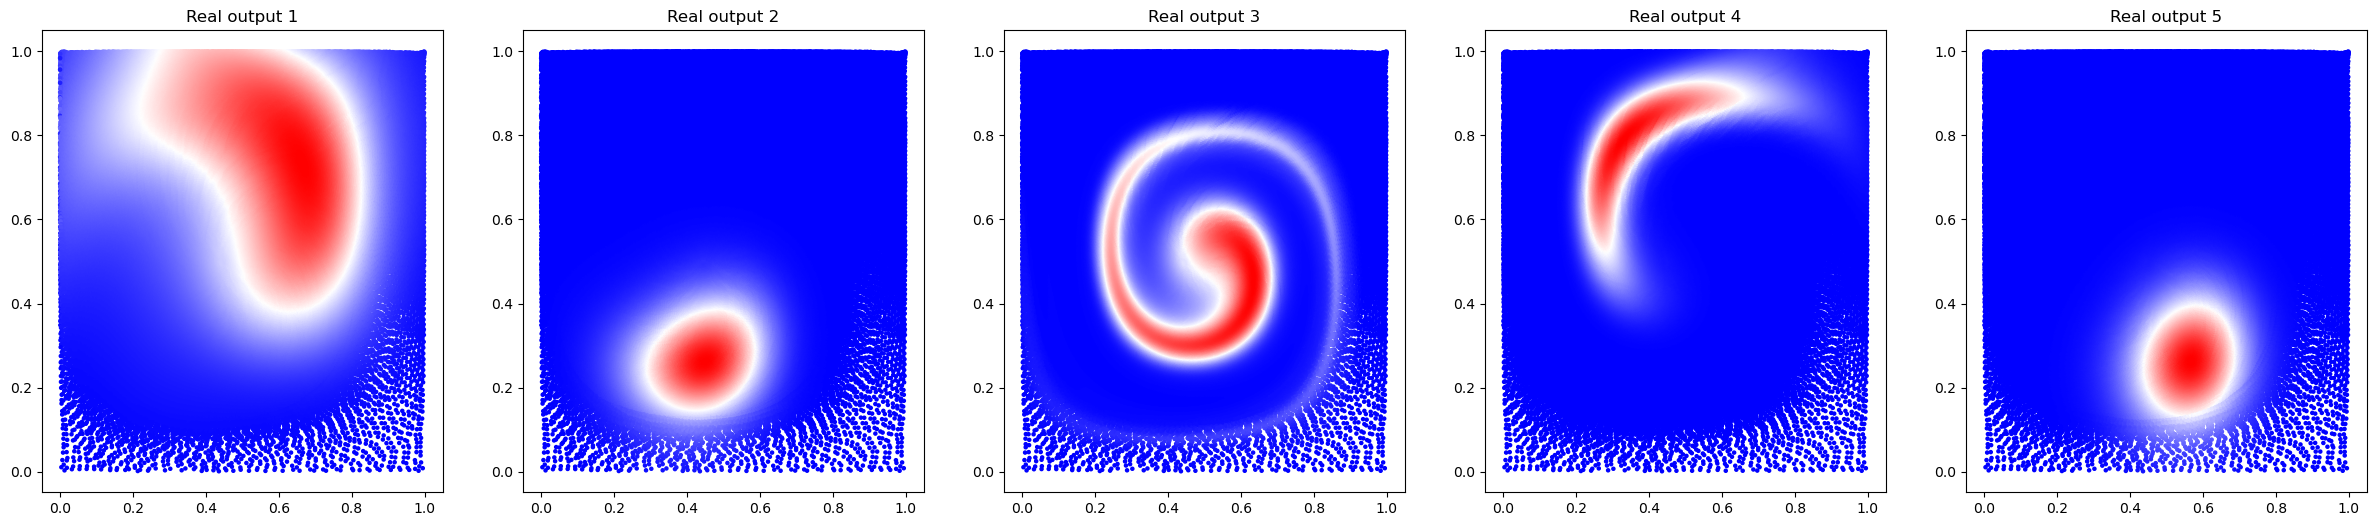

In [30]:
draw_pic(model, real_x, x, real_output, preprocessor, xycoords_check)